# Tic-tac-toe game analysis
The task is to analyze the images of the tic-tac-toe game, find the winner and draw the line that crosses the row of 3 marks (X or O). 

#### Deliverable: 
* Working code (it should be possible to install all the necessary packages to run it from requirements.txt using pip).
* A short report [in English] on the principle of operation of your solution (better with some illustrations).
* The initial game images with the line that crosses the straight line of 3 same marks.


### Impor libraries

These are all my functions writing while working on the project.

In [1]:
from my_funcs import *

Let's review the initial image

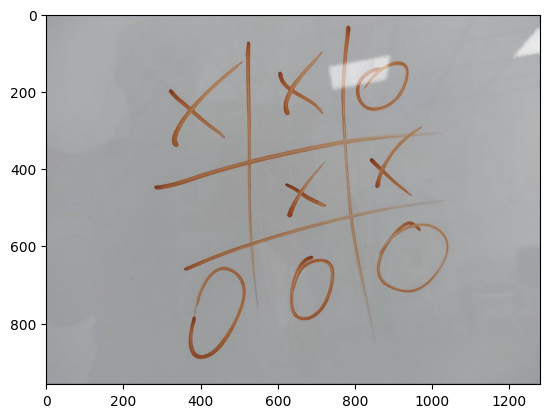

In [2]:
image = cv2.imread('Tic-tac-toe game images/tic_02.jpg')

plt.imshow(image)
plt.show()

Here I decided to attach the mask to the image for further convenient wiping, as a result of experiments, the function <b>process_image</b> was written

The <b>process_image</b> function takes an input image and enhances its sharpness and contrast, converts it to grayscale, reduces noise, preserves edges, and applies adaptive thresholding to detect and emphasize contours in the image. 

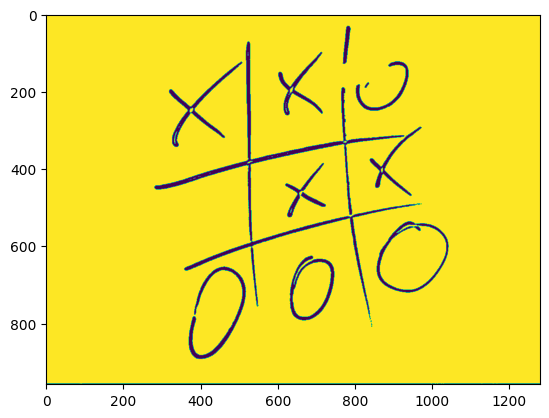

In [3]:
image = cv2.imread('Tic-tac-toe game images/tic_02.jpg')
mask = process_image(image)

plt.imshow(mask)
plt.show()

### Detect contours

Further, it was decided to highlight all the contours on the zooimaged and try to identify crosses and noughts, but here I encountered a number of problems. There were many extra contours, some contours crossed and I could not separate them, it was also difficult to detect the figure in the center, since it was inside another contour. Over time, through experiments, I managed to get approximately the desired result.

(-0.5, 1279.5, 957.5, -0.5)

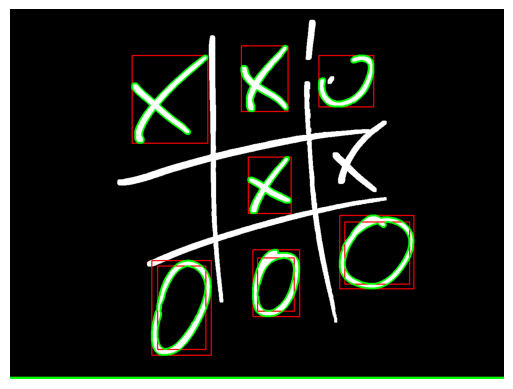

In [4]:
image = cv2.imread('Tic-tac-toe game images/tic_02.jpg')

mask = process_image(image)

_ , mask = cv2.threshold(mask, 60, 255, cv2.THRESH_BINARY)
mask = cv2.erode(mask, np.ones((7, 7), np.uint8))
mask = cv2.bitwise_not(mask)

contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours, max_contour = fillter_contours(contours)

child_contours = get_child_contours(contours)

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours, max_contour = fillter_contours(contours)

contours = contours + child_contours

contours_img = mask.copy()
contours_img = cv2.cvtColor(contours_img, cv2.COLOR_GRAY2BGR)

for contour in contours+child_contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(contours_img, (x, y), (x + w, y + h), (255, 0, 0), 2)
cv2.drawContours(contours_img, contours + child_contours, -1, (0, 255, 0), 3)

plt.imshow(contours_img)
plt.axis('off')

But as you can see the result is still far from necessary, the algorithm still does not allocate all 9 cells for further analysis.

### Detect cells

The main problem further, was to identify the missing cells in the game space, and for this I found a good solution on <a href='https://stackoverflow.com/questions/62946604/fitting-an-orthogonal-grid-to-noisy-coordinates'>stackoverflow</a>. This is Orthogonal mesh adaptations to noisy coordinates. This solution is well suited for my problem in based on this I have already been able to create a framework for missing cells. Here is the result.

(-0.5, 1279.5, 957.5, -0.5)

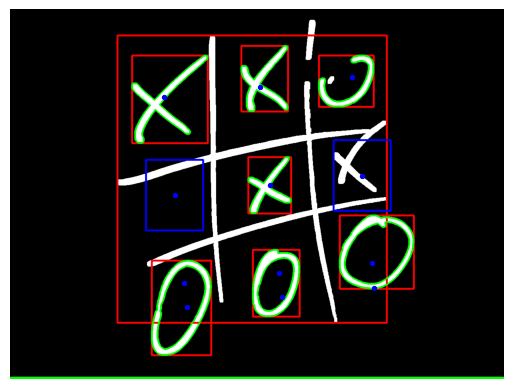

In [5]:
image = cv2.imread('Tic-tac-toe game images/tic_02.jpg')

mask = process_image(image)

_ , mask = cv2.threshold(mask, 60, 255, cv2.THRESH_BINARY)
mask = cv2.erode(mask, np.ones((7, 7), np.uint8))
mask = cv2.bitwise_not(mask)

contours_img_before_filtering = mask.copy()
contours_img_before_filtering = cv2.cvtColor(contours_img_before_filtering, cv2.COLOR_GRAY2BGR)

bounding_boxes = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    bounding_boxes.append((x, y, w, h))

bounding_boxes = merge_boxes(bounding_boxes)
bounding_boxes = filter_ratio(bounding_boxes, filter_ratio=2.5)
bounding_boxes = filter_bounding_boxes(bounding_boxes, cv2.boundingRect(max_contour))

center_boxes = [get_centers(box) for box in bounding_boxes]

x, y, w, h = cv2.boundingRect(max_contour)
cv2.rectangle(contours_img_before_filtering, (x, y), (x + w, y + h), (255, 0, 0), 3)

for x, y, w, h in bounding_boxes:
    cv2.rectangle(contours_img_before_filtering, (x, y), (x + w, y + h), (255, 0, 0), 3)

cv2.drawContours(contours_img_before_filtering, contours, -1, (0, 255, 0), 3)

grid_pts = get_points(center_boxes)
center_points = list(zip(grid_pts['x'], grid_pts['y']))

filtered_points = points_not_in_boxes(center_points, bounding_boxes)

bxs = create_average_boxes(bounding_boxes, filtered_points)

for x, y, w, h in bxs:
    x, y, w, h = int(x), int(y), int(w), int(h)
    cv2.rectangle(contours_img_before_filtering, (x, y), (x + w, y + h), (0, 0, 255), 3)

plt.imshow(contours_img_before_filtering)

x_coords = [point[0] for point in center_points]
y_coords = [point[1] for point in center_points]
plt.scatter(x_coords, y_coords, s=8, c='b')
plt.axis('off')

As you can see, this approach gives a good result, now we can work with a bounding boxese.

### clustering of images

Next, I decided to cluster the image using the Kmeans method. To isolate the features, I applied the VGG model, this will improve the work of Kmeans. I zazdelegid added to the data images of empty cells to the algorithm was easier to divide into clusters of crosses, noughts and empty cells.

c:\Users\krapa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


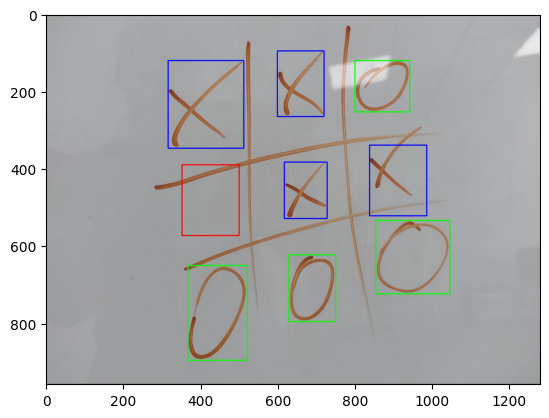

In [6]:
image = cv2.imread('Tic-tac-toe game images/tic_02.jpg')
bounding_boxes = get_image_bounding_boxes(image)
model = VGG16(weights='imagenet', include_top=False)
imgs = label_bounding_boxes(image, bounding_boxes, model)
image_with_boxes = image

for item in imgs:
    if item['box']:
        x, y, w, h = item['box']
        color = (255, 0, 0)
        if item['label'] == 1:
            color = (0, 255, 0)
        elif item['label'] == 2:
            color = (0, 0, 255)
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color, 2)

plt.imshow(image_with_boxes)
plt.show()

As you see, the model copes well with the task and you can begin to detect the winner.

### Check winner and draw line

Next, I sorted all the bounding boxes with coordinates and wrote a function that checks the winner. I found cells that need to draw lines and did it.

Winning cell indexes: ((2, 0), (2, 2))


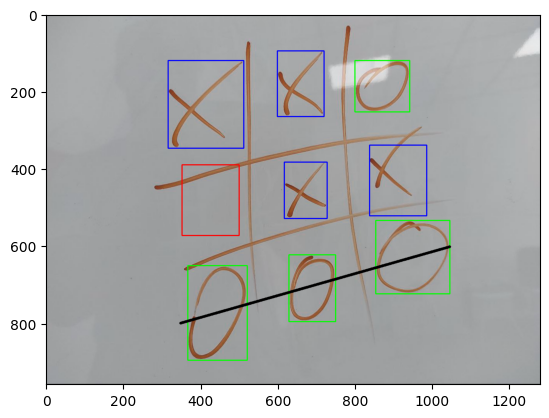

In [7]:
blank_label = 'blank'
for img in imgs:
    if img['box'] is None:
        blank_label = img['label']
        break

for img in imgs:
    if img['label'] == blank_label:
        img['label'] = 'blank'

imgs = list(filter(lambda x: x['box'], imgs))
imgs = sorted(imgs, key=lambda x: x['box'][1])

a1 = sorted(imgs[:3], key=lambda x: x['box'][0])
a2 = sorted(imgs[3:6], key=lambda x: x['box'][0])
a3 = sorted(imgs[6:], key=lambda x: x['box'][0])

board = [a1, a2, a3]

winning_cells = check_winner(board)

if winning_cells is not None:
    print(f'Winning cell indexes: {winning_cells[0], winning_cells[2]}')
else:
    print('Draw.')

box1 = board[winning_cells[0][0]][winning_cells[0][1]]['box']
box2 = board[winning_cells[2][0]][winning_cells[2][1]]['box']

final_image = image

point1 = (box1[0] + box1[2] // 2, box1[1] + box1[3] // 2)
point2 = (box2[0] + box2[2] // 2, box2[1] + box2[3] // 2)

extension_length = 100
dx = point2[0] - point1[0]
dy = point2[1] - point1[1]
length = np.sqrt(dx**2 + dy**2)
new_x1 = point1[0] - int(dx / length * extension_length)
new_y1 = point1[1] - int(dy / length * extension_length)
new_x2 = point2[0] + int(dx / length * extension_length)
new_y2 = point2[1] + int(dy / length * extension_length)

cv2.line(final_image, (new_x1, new_y1), (new_x2, new_y2), (0, 0, 0), 5)  # Зелена лінія

plt.imshow(final_image)
plt.show()

That's all, it was an exciting challenge